In [63]:
import pickle

In [64]:
with open('nbd_array', 'rb') as f:
    nbd = pickle.load(f)

In [71]:
lengths = [len(x[1]) for x in nbd]

Comparing the GRB's :

`nbd[2] = [6,17,23]`

6 = GRB150312403

15 = GRB170130697

In [14]:
import pandas as pd
import numpy as np
from astropy.io import fits

In [28]:
# get the ra and dec values of grbs to compare
lcdf = pd.read_csv('gbmdatacleaned.csv', index_col = 0) # light curve data frame
grb_index = [6,15,2]
ra = [] #to hold ra values
dec = [] #to hold dec values
grbnames = []
for i in grb_index:
    ra.append(lcdf.iloc[i].ra_val)
    dec.append(lcdf.iloc[i].dec_val)
    grbnames.append(lcdf.iloc[i]['name'])

grbnumbers = [x[3:] for x in grbnames]

In [31]:
# find the name of the brightest NaI detector
import estimate_source_angles_detectors as esad

for i in range(len(grb_index)):
    b = esad.angle_to_grb(ra[i],
                          dec[i],
                          '/Users/dimrisudhanshu/Downloads/current/glg_trigdat_all_bn' + grbnumbers[i] + '_v01.fit')
    print(b[0])

n3
n3
n8


In [9]:
def dfFromFitFile(fitfile):
    '''
    function to get a DataFrame from a raw fitfile
    '''
    # convert the EVENTS header into a dataframe
    timedf = pd.DataFrame(fitfile[2].data)
    
    # change the dtype of both the columns
    timedf.PHA = timedf.PHA.astype('int32')
    timedf.TIME = timedf.TIME.astype('float')
    
    # get trigger time from the fits file
    trigtime = fitfile[0].header['TRIGTIME']
    
    # make a new translated time column
    timedf['TTIME'] = timedf.TIME - trigtime
    
    return timedf

In [35]:
#open the fits file corresponding to the brightest NaI detectors
fitfile1 = fits.open('/Users/dimrisudhanshu/Downloads/current/glg_tte_n3_bn150312403_v01.fit')
fitfile2 = fits.open('/Users/dimrisudhanshu/Downloads/current/glg_tte_n3_bn170130697_v00.fit')
fitfile3 = fits.open('/Users/dimrisudhanshu/Downloads/current/glg_tte_n8_bn141205018_v00.fit')

In [36]:
timedf1 = dfFromFitFile(fitfile1)
timedf2 = dfFromFitFile(fitfile2)
timedf3 = dfFromFitFile(fitfile3)

In [37]:
def get_t90(grbname):
    '''
    function to get the t90 value of a given grb from the cleaned 
    gbm dataset
    grbname = name of the grb 
    '''
    lcdf = pd.read_csv('gbmdatacleaned.csv', index_col = 0)
    result = lcdf.loc[lcdf.name == grbname] #find the row with name = grbname
    # print(result)
    t90 = result.t90 #this is an object
    return float(t90.iloc[0].strip()) #strip to remove the trailing whitespaces

In [38]:
def getBinSize(t90):
    if t90 >= 2:
        return 1
    else:
        return 0.1

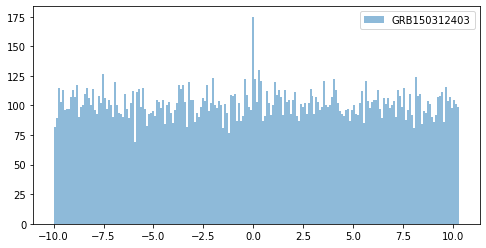

In [62]:
# print the histogram to get the light curve
import matplotlib.pyplot as plt

t90_1 = get_t90(grbnames[0])
t90_2 = get_t90(grbnames[1])
t90_3 = get_t90(grbnames[2])

plt.figure(figsize = (8,4))
start_1, end_1 = -10, t90_1 + 10
start_2, end_2 = -10, t90_2 + 10
start_3, end_3 = -10, t90_3 + 10

bin_size1 = getBinSize(t90_1)
bin_size2 = getBinSize(t90_2)
bin_size3 = getBinSize(t90_3)

N1 = plt.hist(timedf1.TTIME, bins = int((end_1 - start_1)/bin_size1),
              range = (start_1, end_1), alpha = 0.5, label = grbnames[0])
# N2 = plt.hist(timedf2.TTIME, bins = int((end_2 - start_2)/bin_size2),
              # range = (start_2, end_2), alpha = 0.5, label = grbnames[1])
# N3 = plt.hist(timedf3.TTIME, bins = int((end_3 - start_3)/bin_size3),
              # range = (start_3, end_3), alpha = 0.5, label = grbnames[2])


plt.legend(loc = 'upper right')

In [42]:
n2 = N2[0]
n1 = N1[0]
n3 = N3[0]

Now `n1`, `n2` and `n3` are required light curves

In [43]:
# length of both time series
print(len(n1), len(n2), len(n3))

203 49 33


211693.0 2762.0


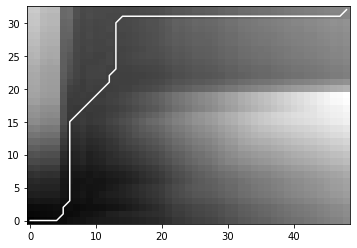

In [49]:
# Applying DTW to these light curves
from dtw import dtw
manhattan_distance = lambda x, y : np.abs(x-y)
d1, cost_matrix, acc_cost_matrix, path = dtw(n1,n3, dist = manhattan_distance)
d2, cost_matrix, acc_cost_matrix, path = dtw(n2,n3, dist = manhattan_distance)
print(d1, d2)

#visualizing the plot
plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.show()

### TODO
---
1. Light Curve Simulation

In [50]:
from scipy.stats import poisson, norm
import time
import seaborn as sns

In [51]:
simulated_curves = []
for i in range(1000):
    new_curve = []
    for n in n3:
        new_curve.append(poisson.rvs(mu = n, size = 1)[0])
    simulated_curves.append(new_curve)

In [52]:
start_time = time.time()
dtw_list = []
for curve in simulated_curves:
    d, a, b, c = dtw(n3, curve, dist = manhattan_distance)
    dtw_list.append(d)
end_time = time.time()
print(f'Total time = {end_time - start_time}')

Total time = 5.4456751346588135


815.278 108.11734697077985


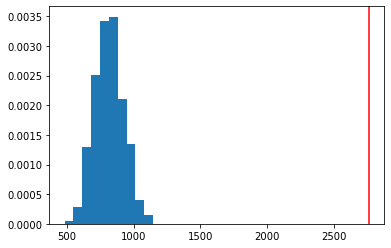

In [56]:
mu, std = norm.fit(dtw_list)
print(mu, std)
plt.hist(dtw_list, density=True)
plt.axvline(d2, color='red')